In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append("..")

import pandas as pd
import numpy as np
import seaborn

pd.set_option('display.max_rows', 500)

In [2]:
import re
from scipy.stats import entropy

df = pd.read_csv("../contrastes/provincias.csv", quotechar="\"", decimal=",")
df = df.set_index("palabra")

fnorm_vars = [c for c in df.columns if re.match(r'fnorm_.*', c)]
cant_palabras = [c for c in df.columns if re.match(r'.*Palabras$', c)]
cant_personas = [c for c in df.columns if re.match(r'.*Personas$', c)]

In [3]:
from iv_helpers import simulated_shuffled_entropy_multinomial

fn = lambda ws: simulated_shuffled_entropy_multinomial(ws, len(cant_palabras))

df["entropy_palabras"] = df[cant_palabras].apply(entropy, axis=1, raw=True)
df["entropy_personas"] = df[cant_personas].apply(entropy, axis=1, raw=True)
df["shuffled_entropy_personas"] = df.cantUsuariosTotal.apply(fn)
df["shuffled_entropy_palabras"] = df.cantPalabra.apply(fn)

In [4]:
print df.cantUsuariosTotal.min()
print df.cantPalabra.min()

6
41


In [5]:
cantPalabrasTotales = sum(df.cantPalabra)
df['fnormArgentina'] = df['cantPalabra']/cantPalabrasTotales

In [6]:
df.fnormArgentina

palabra
a                    2.632803e-02
aa                   2.267000e-05
aaa                  8.730575e-05
aaaca                2.387432e-07
aaadentro            3.342405e-07
aaag                 3.979054e-07
aaaggg               3.979054e-07
aaah                 4.978592e-05
aaahh                3.597065e-06
aaahhh               1.037737e-05
aaahi                2.546594e-07
aaahora              2.493540e-07
aaai                 1.522651e-06
aaaii                2.758811e-07
aaaiii               5.889000e-07
aaaj                 6.525648e-07
aaajaja              2.705757e-07
aaajajaja            4.934027e-07
aaajajajaja          4.509594e-07
aaajajajajaja        5.040135e-07
aaajajajajajaja      2.864919e-07
aaajajajajajajaja    2.334378e-07
aaal                 1.596927e-06
aaala                8.541702e-07
aaalgo               9.761946e-07
aaalguien            3.501567e-07
aaall                2.334378e-07
aaalta               1.013332e-06
aaalto               1.050470e-06
aaam  

Si le aplico el logaritmo a la cantidad de la Palabra, ya no tiene tanta importancia la cantidad y por lo tanto, las palabras palabras comunes como **que**, **y**,**el**,etc. dejan de tener tanto valor de información

In [16]:
import math
df['normCantPalabras']=(df.cantPalabra.apply(math.log,args=(2,))-df.cantPalabra.apply(math.log,args=(2,)).min())/(df.cantPalabra.apply(math.log,args=(2,)).max()-df.cantPalabra.apply(math.log,args=(2,)).min())
df['normCantPersonas']=(df.cantUsuariosTotal.apply(math.log,args=(2,))-df.cantUsuariosTotal.apply(math.log,args=(2,)).min())/(df.cantUsuariosTotal.apply(math.log,args=(2,)).max()-df.cantUsuariosTotal.apply(math.log,args=(2,)).min())
# df['normCantPalabras']=(df.cantPalabra-df.cantPalabra.mean())/(df.cantPalabra.std())
# df['normCantPersonas']=(df.cantUsuariosTotal-df.cantUsuariosTotal.mean())/(df.cantUsuariosTotal.std())

In [75]:
df.fnormArgentina.describe()["mean"]

1.3179050581196133e-05

In [17]:
from iv_helpers import lugares
places = lugares()
print len(places)
df['esLugar'] = np.where(df.index.str.decode(encoding='utf-8').isin(places),'lugar','ok')

3006


### Normalizo el valor de la cantidad de ocurrencias de una palabra y de usuarios que la utilizan.

$$ norm_{CantPalabras} = \frac{log_2(\#Palabra)- min(log_2(\#Palabra))}{max(log_2(\#Palabra)) - min(log_2(\#Palabra))}$$

$$norm_{CantPersonas} = \frac{log_2(\#Usuarios)- min(log_2(\#Usuarios))}{max(log_2(\#Usuarios)) - min(log_2(\#Usuarios))}$$

De esta forma, estos dos valores están en el rango 0-1

La métrica llamada $InformationValue_{PersonasPalabras}$

$$InformationValue_{PersonasPalabras} =  norm_{CantPalabras} * norm_{CantPersonas} * (\widehat{H}_{personas} - H_{personas}) * (\widehat{H}_{palabras} - H_{palabras})$$

donde $\widehat{H}$ es la entropía con las cantidades distribuidas uniformemente y H es la entropía común

$$ InformationValue_{PersonasPalabras} =  norm_{CantPalabras} * norm_{CantPersonas} * (\widehat{H}_{personas} - H_{personas}) * (\widehat{H}_{palabras} - H_{palabras}) $$

In [69]:
import math

df["information_value_palabras"] = (df.cantPalabra.apply(math.log,args=(2,))) * (df.shuffled_entropy_palabras - df.entropy_palabras)
df["information_value_personas"] = (df.cantPalabra.apply(math.log,args=(2,))) * (df.shuffled_entropy_personas - df.entropy_personas)
# df["information_value_personas_palabras"] = (df.cantUsuariosTotal.apply(math.log,args=(2,))) * (df.cantPalabra.apply(math.log,args=(2,))) * (df.shuffled_entropy_personas - df.entropy_personas) * (df.shuffled_entropy_palabras - df.entropy_palabras)
# df["information_value_personas_palabras"] = df.normCantPalabras * df.normCantPersonas * (df.shuffled_entropy_personas - df.entropy_personas) * (df.shuffled_entropy_palabras - df.entropy_palabras)
df["information_value_personas_palabras"] = df.normCantPalabras * df.normCantPersonas * (df.shuffled_entropy_personas - df.entropy_personas) * (df.shuffled_entropy_palabras - df.entropy_palabras)
# df["information_value_personas_palabras"] = df.cantPalabra * df.cantUsuariosTotal * (df.shuffled_entropy_personas - df.entropy_personas) * (df.shuffled_entropy_palabras - df.entropy_palabras)

#df["information_value_FnormMax"] = (df.FnormMax) * (df.shuffled_entropy - df.entropy)

df.sort_values(by="information_value_personas_palabras", ascending=False, inplace=True)
df['rankPalabras'] = df['information_value_palabras'].rank(ascending=False).astype('int64')
df['rankPersonas'] = df['information_value_personas'].rank(ascending=False).astype('int64')
df['rankPalabras_Personas'] = df['information_value_personas_palabras'].rank(ascending=False).astype('int64')


palabrasPersonas = [c for c in df.columns if re.match(r'.*PalabrasPersonas', c)]
# df = df.set_index('palabra')
resumed = df[df.columns.difference(cant_palabras+fnorm_vars + palabrasPersonas)]
df.iloc[:1000][['fnormArgentina','cantPalabra','esLugar','cantUsuariosTotal','provinciaFnormMax','rankPalabras','rankPersonas','rankPalabras_Personas','normCantPersonas','normCantPalabras','shuffled_entropy_personas','entropy_personas']]

,fnormArgentina,cantPalabra,esLugar,cantUsuariosTotal,provinciaFnormMax,rankPalabras,rankPersonas,rankPalabras_Personas,normCantPersonas,normCantPalabras,shuffled_entropy_personas,entropy_personas
palabra,,,,,,,,,,,,
chivilcoy,2.161422e-05,4074,lugar,469,buenosaires,4,4,1,0.532714,0.379500,3.106309,0.558161
oberá,2.292996e-05,4322,lugar,378,misiones,3,3,2,0.506352,0.384377,3.116167,0.569656
ushuaia,7.940069e-05,14966,lugar,1006,tierradelfuego,1,50,3,0.625981,0.486874,3.129850,1.453279
ush,1.133765e-05,2137,ok,465,tierradelfuego,11,5,4,0.531668,0.326256,3.114483,0.362702
obera,1.117318e-05,2106,lugar,410,misiones,17,11,5,0.516283,0.325050,3.104974,0.543877
viedma,3.493079e-05,6584,lugar,666,rionegro,7,51,6,0.575573,0.419112,3.121059,1.294115
breñas,1.374100e-05,2590,lugar,170,chaco,6,2,7,0.408690,0.342121,3.022820,0.232404
bragado,1.488166e-05,2805,lugar,294,buenosaires,9,10,8,0.475637,0.348702,3.096871,0.619135
logroño,1.375161e-05,2592,lugar,132,larioja,5,1,9,0.377771,0.342184,3.000368,0.089018


## Hago un dataframe con las palabras candidatas, cada una con las cantidades de ocurrencias por provincia de forma ordenada

In [57]:
cant = [c for c in df.columns if re.match(r'.*Palabras$', c) and (not re.match(r'.*norm', c) ) and (not re.match(r'.*rank', c) )]

dfCant = df[cant]
# Palabras candidatas según la AAL
palabras = ["quedarla","mitaí","angá","yungas","mensajeras","yarco","yarca",
"malpegar","malpegue","malpegada","tareferos","hartante","guaracha","esar","ñeri",
"piadina","chombi","achilata","pollerear","juntadera","pachata","chamigo","chamiga",
"chaque","pichar","tortita","guaso","guasa","comparsero","comparsera","sina","lape","veme","porronear",
"fajita","jia","jía","asada","asar","manso","cora","cumpa","pingo","charro","pinchila","oyo","ura","yuto",
"yagua","cantobar","cha","bombolo","bombola","yafu","jal","gatera","atina",
"guampudo","guampuda","mamila","chui","tico"]
# top_n = 23
# dfCant = dfCant.loc[palabras].dropna()
# dfLargestNum = pd.DataFrame({col: dfCant.T[col].nlargest(top_n).tolist() 
#                   for n, col in enumerate(dfCant.T)}).T
# dfLargestNum

In [58]:
dfC = df.sort_values(by="information_value_personas_palabras", ascending=False, inplace=False)[cant]


In [59]:
sort_xs = dfC.apply(np.sort, axis=1)
sort_index = dfC.apply(np.argsort, axis=1)
sort_xs.columns = range(23)
sort_index.columns = range(23)
cols = sort_xs.columns.tolist()
cols = cols[::-1]
sort_xs = sort_xs[cols]
sort_index = sort_index[cols]
sort_xs.columns= range(23)
sort_index.columns = range(23)

In [60]:
percent = sort_xs.div(sort_xs.sum(axis=1), axis='index')

In [61]:
# percent.drop('total', axis=1, inplace=True)
percent

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
palabra,,,,,,,,,,,,,,,,,,,,,
chivilcoy,0.979872,0.003682,0.003436,0.002209,0.001718,0.001227,0.000982,0.000982,0.000736,0.000736,...,0.000736,0.000491,0.000245,0.000245,0.000245,0.000245,0.000000,0.000000,0.000000,0.000000
oberá,0.981953,0.007867,0.003702,0.001157,0.000925,0.000925,0.000694,0.000463,0.000463,0.000463,...,0.000231,0.000231,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ushuaia,0.962649,0.006749,0.004410,0.003140,0.002339,0.002205,0.002071,0.001938,0.001871,0.001670,...,0.001270,0.000935,0.000802,0.000735,0.000535,0.000535,0.000535,0.000535,0.000535,0.000267
ush,0.981750,0.006551,0.001404,0.001404,0.000936,0.000936,0.000936,0.000936,0.000936,0.000468,...,0.000468,0.000468,0.000468,0.000468,0.000468,0.000000,0.000000,0.000000,0.000000,0.000000
obera,0.962013,0.014245,0.005223,0.002374,0.002374,0.002374,0.001899,0.001899,0.001425,0.000950,...,0.000950,0.000475,0.000475,0.000475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
viedma,0.938335,0.017011,0.013062,0.005923,0.005164,0.004253,0.002430,0.002278,0.001519,0.001367,...,0.000911,0.000759,0.000759,0.000759,0.000608,0.000456,0.000304,0.000304,0.000304,0.000152
breñas,0.994981,0.001931,0.001931,0.000386,0.000386,0.000386,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
bragado,0.970766,0.006417,0.005348,0.003922,0.003922,0.002139,0.002139,0.001783,0.001426,0.000713,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
logroño,0.999228,0.000386,0.000386,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


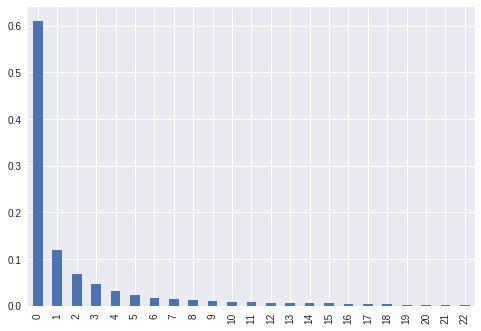

In [62]:
percent.loc[palabras].mean().T.plot(kind='bar')

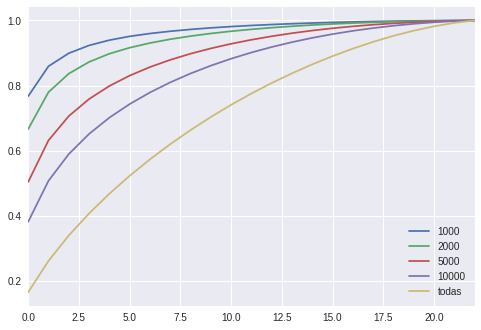

In [63]:
dfAcum = pd.DataFrame()
dfAcum['1000'] = percent.iloc[:1000].cumsum(axis=1).mean()
dfAcum['2000'] = percent.iloc[:2000].cumsum(axis=1).mean()
dfAcum['5000'] = percent.iloc[:5000].cumsum(axis=1).mean()
dfAcum['10000'] = percent.iloc[:10000].cumsum(axis=1).mean()
dfAcum['todas'] = percent.cumsum(axis=1).mean()
dfAcum.plot()

# Vemos como se distribuye la suma acumulada de proporciones de las palabras

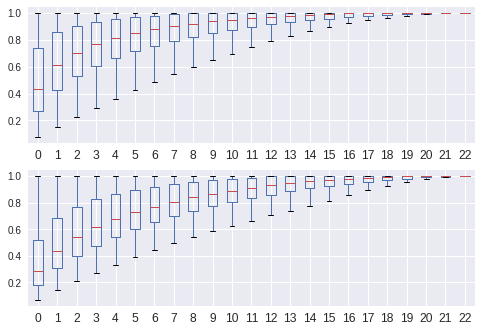

In [64]:
fig, axes = plt.subplots(nrows=2, ncols=1)
percent.iloc[:5000].cumsum(axis=1).boxplot(return_type='axes',ax=axes[0])
percent.iloc[:10000].cumsum(axis=1).boxplot(return_type='axes',ax=axes[1])
# percent.cumsum(axis=1).boxplot(return_type='axes',ax=axes[1])


In [109]:
regiones = pd.DataFrame()
regiones = percent.cumsum(axis=1)
regiones
# regiones["thresh80"] =
def calc(row,thresh):
    for i in range(len(row)):
        if row[i]> thresh:
            return i
    
regiones[:5000].apply(calc,args=(0.8,),axis=1).mean()
regiones[:5000].apply(calc,args=(0.7,),axis=1).mean()

3.0238

In [167]:
cols = regiones[:5000].apply(calc,args=(0.7,),axis=1)
a = sort_index.iloc[1].iloc[:cols.iloc[1]+1]
np.take(cant,a)

array(['misionesPalabras'], 
      dtype='|S22')

In [288]:
cantS = pd.Series(cant)
def provs(row,thresh):
    for i in range(len(row)):
        if row[i]> thresh:
            cant = sort_index.loc[row.name].iloc[:i+1].tolist()
            print cant
            print [provs[x] for x in cant]
            return [provs[x] for x in cant]
#             return sort_index.loc[row.name].iloc[:i+1]
#             return np.take(cant,sort_index.loc[row.name].iloc[:2])


print regiones[:5000].apply(provs,args=(0.8,),axis=1)
# print regiones[:5000].apply(provs,args=(0.75,),axis=1).apply(len).mean()
# print regiones[:5000].apply(provs,args=(0.70,),axis=1).apply(len).mean()
# print regiones[:5000].apply(provs,args=(0.90,),axis=1).apply(len).mean()
# print regiones[:5000].apply(provs,args=(0.60,),axis=1).apply(len).mean()



[0]
[0]


TypeError: ("'function' object has no attribute '__getitem__'", u'occurred at index chivilcoy')

In [286]:
provs = [x.replace("Palabras","") for x in cant]
provs[0]

'buenosaires'

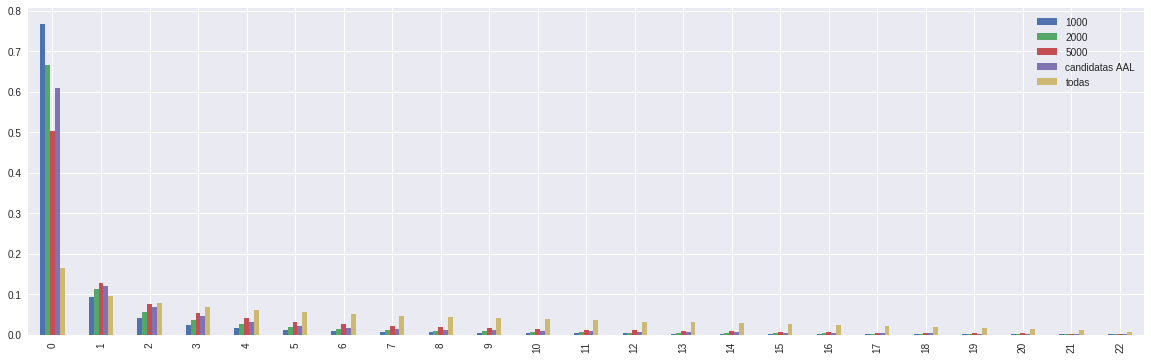

In [65]:
dfp = pd.DataFrame()
dfp['1000'] = percent.iloc[0:1000].mean().T
dfp['2000'] = percent.iloc[0:2000].mean().T
dfp['5000'] = percent.iloc[0:5000].mean().T
dfp['candidatas AAL'] = percent.loc[palabras].mean().T
dfp['todas'] = percent.mean().T
dfp.plot(kind='bar',figsize=[20,6])

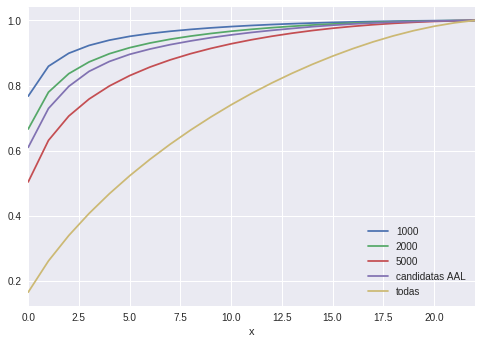

In [272]:
dfp = pd.DataFrame()
dfp['1000'] = percent.iloc[0:1000].mean().T.cumsum()
dfp['2000'] = percent.iloc[0:2000].mean().T.cumsum()
dfp['5000'] = percent.iloc[0:5000].mean().T.cumsum()
dfp['candidatas AAL'] = percent.loc[palabras].mean().T.cumsum()
dfp['todas'] = percent.mean().T.cumsum()

ax= dfp.plot(kind='line')
ax.set_xlabel("x")
ax2= ax.get_figure()


ax2.savefig("output.png",dpi=300)
ax2.savefig?


In [44]:
dfCant = df[cant]

## Hago un dataframe con las palabras candidatas, cada una con las provincias ordenadas según cuantas veces ocurre una palabra en cada una de ellas

In [ ]:
df.sort_values(by='information_value_personas_palabras',ascending=False,inplace=True)
df.iloc[:7000][['cantPalabra','cantUsuariosTotal','provinciaFnormMax','rankPalabras','rankPersonas','rankPalabras_Personas']]
df.iloc[:7000][['cantPalabra','cantUsuariosTotal','provinciaFnormMax','rankPalabras','rankPersonas','rankPalabras_Personas','entropy_palabras','entropy_personas']].to_csv('resumido.csv')

In [ ]:
df.iloc[:10000].plot.scatter(x='rankPalabras_Personas',y='rankPersonas')
df.iloc[:10000].plot.scatter(x='rankPalabras_Personas',y='rankPalabras')
df.iloc[:10000].plot.scatter(x='rankPalabras',y='rankPersonas')

In [ ]:
df.iloc[:1000].plot.scatter(x='entropy_palabras',y='rankPersonas')
df.iloc[:10000].plot.scatter(x='entropy_palabras',y='rankPalabras')
df.iloc[:10000].plot.scatter(x='entropy_palabras',y='rankPalabras_Personas')

In [ ]:
df.iloc[:1000].plot.scatter(x='entropy_personas',y='rankPersonas')
df.iloc[:10000].plot.scatter(x='entropy_personas',y='rankPalabras')
df.iloc[:10000].plot.scatter(x='entropy_personas',y='rankPalabras_Personas')

## Guardo los listados (resumidos, y extendidos) ordenados en base a las dos médidas de información

In [ ]:
df.sort_values(by="information_value_palabras", ascending=False, inplace=True)
resumed = df[df.columns.difference(cant_palabras+fnorm_vars + palabrasPersonas)]
resumed.to_csv('ivalue_entropia_palabras_resumida.csv')
df.to_csv('ivalue_entropia_palabras.csv')

df.sort_values(by="information_value_personas", ascending=False, inplace=True)
resumed = df[df.columns.difference(cant_palabras+fnorm_vars + palabrasPersonas)]
resumed.to_csv('ivalue_entropia_personas_resumida.csv')
df.to_csv('ivalue_entropia_personas.csv')

df.sort_values(by="information_value_personas_palabras", ascending=False, inplace=True)
resumed = df[df.columns.difference(cant_palabras+fnorm_vars + palabrasPersonas)]
resumed = resumed[['cantPalabra','esLugar','cantUsuariosTotal','fnormArgentina','provinciaFnormMax','rankPalabras','rankPersonas','rankPalabras_Personas']]
resumed.to_csv('ivalue_entropia_personas_palabras_resumida.csv')


df.to_csv('ivalue_entropia_personas_palabras.csv')

In [ ]:
df.sort_values(by="information_value_palabras", ascending=False, inplace=True)
df2 = df.reset_index()
ax = df2.information_value_palabras.plot.line()
df.sort_values(by="information_value_personas", ascending=False, inplace=True)
df2 = df.reset_index()

df2.information_value_personas.plot.line()
ax.legend([u'Valor de la inforamción palabras',u'Valor de la inforamción personas'])

ax.set_xlabel(u'Posición de palabra')
ax.set_ylabel(u'Valor de la inforamción')


In [ ]:
df2 = df.sort_values(by="information_value_personas", ascending=False)
df2 = df2.reset_index()
ax2 = df2.information_value_personas.plot(xlim=[0,5000])
df2 = df.sort_values(by="information_value_palabras", ascending=False)
df2 = df2.reset_index()
ax2 = df2.information_value_palabras.plot(xlim=[0,5000])
ax2.legend([u'Valor de la inforamción personas',u'Valor de la inforamción palabras'])

df2 = df.sort_values(by="information_value_personas_palabras", ascending=False)
df2 = df2.reset_index()
ax2 = df2.information_value_personas_palabras.plot(xlim=[0,5000])


ax2.set_xlabel(u'Posición de palabra')
ax2.set_ylabel(u'Valor de la inforamción')


In [ ]:
df2 = df.sort_values(by="information_value_personas_palabras", ascending=False)
df2 = df2.reset_index()
ax2 = df2.information_value_personas_palabras.plot(xlim=[0,5000])


ax2.set_xlabel(u'Posición de palabra')
ax2.set_ylabel(u'Valor de la inforamción')

In [ ]:
df.plot.scatter(x="entropy_personas", y="cantUsuariosTotal", ylim=[0, 1000])

In [ ]:
df.plot.scatter(x="entropy_personas", y="information_value_personas", ylim=[0, 30])

In [ ]:
df.plot.scatter(x="cantUsuariosTotal", y="information_value_palabras", ylim=[0, 28])

In [ ]:
plt.figure(1)
df.plot.scatter(x="entropy_personas", y="provinciaSinEsaPalabra")
plt.xlabel("Entropia personas")
plt.ylabel("provinvias sin esa palabra")


plt.show()


In [ ]:
plt.figure(2)
df.plot.scatter(x="entropy_palabras", y="provinciaSinEsaPalabra")
plt.xlabel("Entropia palabras")
plt.ylabel("Provincias sin esa palabra")

In [ ]:
df.plot.scatter(y="information_value_personas", x="cantPalabra", logx=True)

In [ ]:
df.information_value_personas.hist(bins=20)

In [ ]:
resumed[df.information_value_personas < 0].iloc[:100]

In [ ]:
df.plot.scatter(x="provinciaSinEsaPalabra", y="information_value_personas")

In [ ]:
df.plot.scatter(x="provinciaSinEsaPalabra", y="entropy_personas")

In [ ]:
ax = df.iloc[:1000].plot(kind='scatter',x='information_value_personas',y='information_value_palabras')
plt.show()

In [ ]:
df[df.provinciaSinEsaPalabra > 17].iloc[:5000][["cantPalabra", "provinciaSinEsaPalabra"]]

In [ ]:
(df.shuffled_entropy_personas - df.entropy_personas).describe()

In [ ]:
df.plot.scatter(x="entropy_personas", y="information_value_personas")

In [ ]:
df.plot.scatter(x="entropy_palabras", y="information_value_palabras")

In [ ]:
df.iloc[:1000].plot.scatter(x="rankPalabras_Personas", y="cantUsuariosTotal",ylim=[0,500])

df.plot.scatter(x="entropy_palabras", y="information_value_personas_palabras")
df.plot.scatter(x="entropy_personas", y="information_value_personas_palabras")


In [ ]:
df.iloc[:5000][df.iloc[:5000].esLugar == 'lugar'].count()